In [15]:
import torch
import torch.optim as opt
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms  as transforms

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.device(0))

True
GeForce MX350
1
0


In [24]:
mb_size = 64

transform = transforms.ToTensor()
train_data = torchvision.datasets.MNIST('./data/', download=True, transform=transform, train=True)
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=mb_size)

In [25]:
data_iter = iter(train_loader)

imgs, labels = data_iter.next()

In [26]:
imgs.shape

torch.Size([64, 1, 28, 28])

In [27]:
def imshow(imgs):
    imgs = torchvision.utils.make_grid(imgs)
    npimgs = imgs.numpy()
    plt.figure(figsize=(8, 8))
    plt.imshow(np.transpose(npimgs, (1,2,0)), cmap='Greys_r')
    plt.xticks([])
    plt.yticks([])
    plt.show()

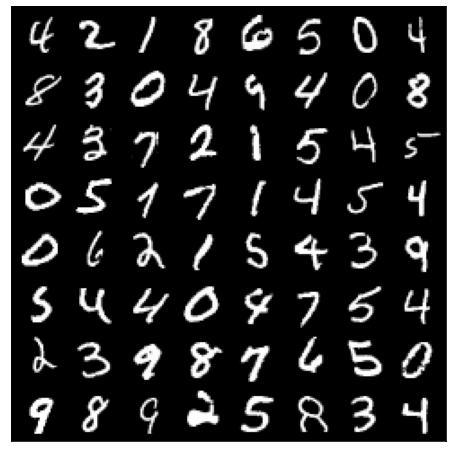

In [28]:
imshow(imgs)

In [29]:
Z_dim = 100
H_dim = 128
X_dim = imgs.view(imgs.size(0), -1).size(1)

print(Z_dim, H_dim, X_dim)

device = 'cuda'

100 128 784


In [30]:
class Gen(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(Z_dim, H_dim),
            nn.ReLU(),
            nn.Linear(H_dim, X_dim),
            nn.Sigmoid()
        )
    
    def forward(self, input):
        return self.model(input)

In [31]:
G = Gen().to(device)

In [32]:
class Dis(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(X_dim, H_dim),
            nn.ReLU(),
            nn.Linear(H_dim, 1),
            nn.Sigmoid()
        )
        
    def forward(self, input):
        return self.model(input)

In [33]:
D = Dis().to(device)

In [34]:
print(G)
print(D)

Gen(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=784, bias=True)
    (3): Sigmoid()
  )
)
Dis(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
    (3): Sigmoid()
  )
)


In [35]:
lr = 1e-3

g_opt = opt.Adam(G.parameters(), lr=lr)
d_opt = opt.Adam(D.parameters(), lr=lr)

Epoch:0,   G_loss:5.080076949174471,    D_loss:0.12219764536339989


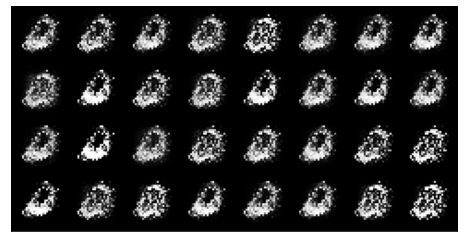

Epoch:1,   G_loss:4.297942181640088,    D_loss:0.12532464680728564


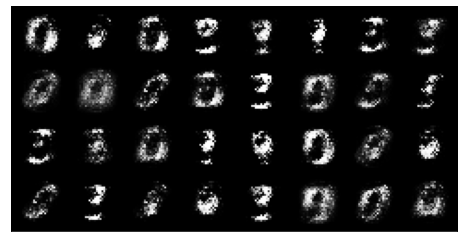

Epoch:2,   G_loss:4.008439965593789,    D_loss:0.2073309111045495


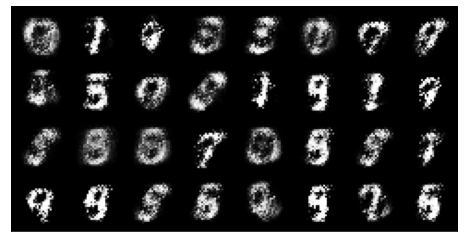

Epoch:3,   G_loss:3.9902161452561806,    D_loss:0.30459995134902407


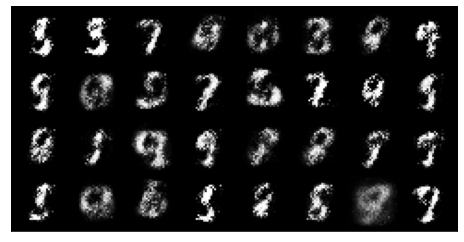

Epoch:4,   G_loss:3.4322746824354,    D_loss:0.4346343174036632


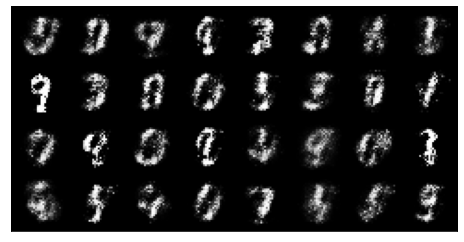

Epoch:5,   G_loss:3.0847462883381955,    D_loss:0.6645695066718913


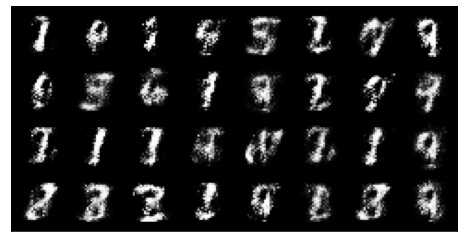

Epoch:6,   G_loss:2.9817489003067585,    D_loss:0.7821545892877619


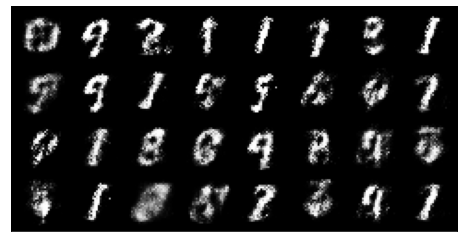

Epoch:7,   G_loss:2.5710196156999956,    D_loss:0.8270327602622352


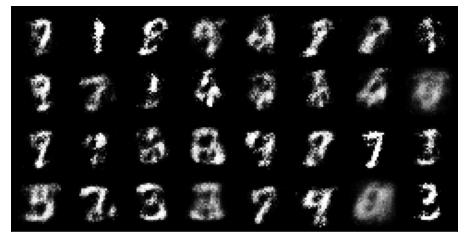

Epoch:8,   G_loss:2.4094465242774246,    D_loss:0.8721447937778318


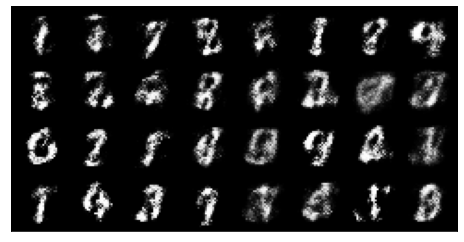

Epoch:9,   G_loss:2.3004976245386004,    D_loss:0.915362096703383


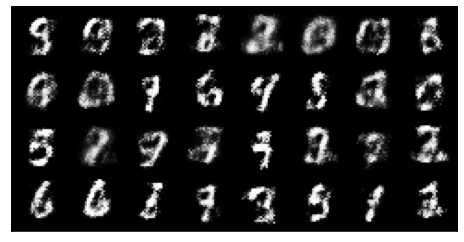

Epoch:10,   G_loss:2.161030387319227,    D_loss:0.9670536198468604


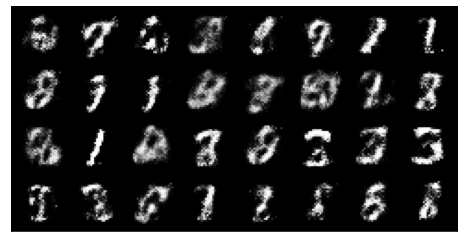

Epoch:11,   G_loss:2.0703451846962544,    D_loss:0.9859121421506918


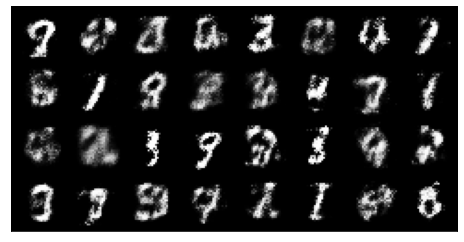

Epoch:12,   G_loss:1.921104849020301,    D_loss:1.0389775948356719


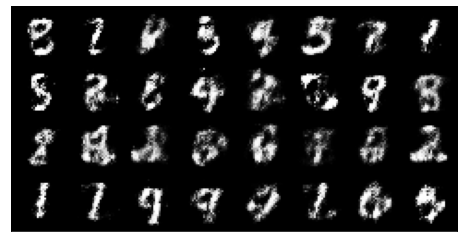

Epoch:13,   G_loss:1.9131558397685542,    D_loss:0.9872994271676931


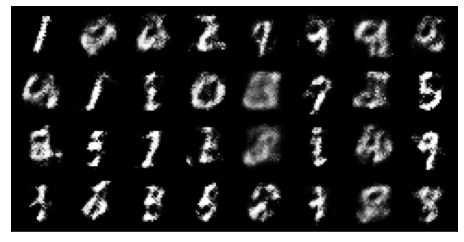

Epoch:14,   G_loss:1.7800044122535283,    D_loss:0.995591993969895


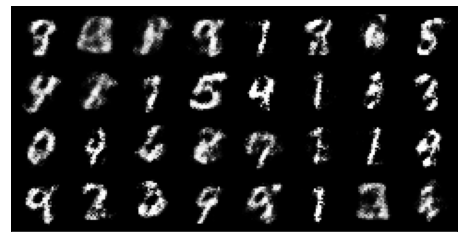

Epoch:15,   G_loss:1.7618306221992477,    D_loss:0.9862874442580413


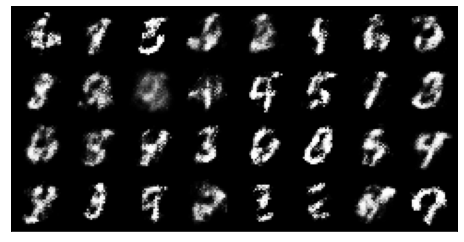

Epoch:16,   G_loss:1.72638265829859,    D_loss:1.0159406991147284


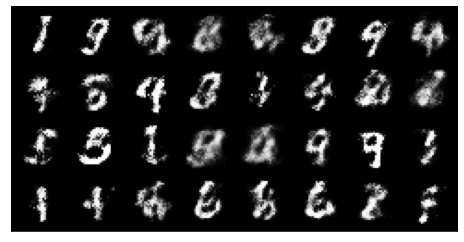

Epoch:17,   G_loss:1.6445477397711292,    D_loss:1.0182280750798265


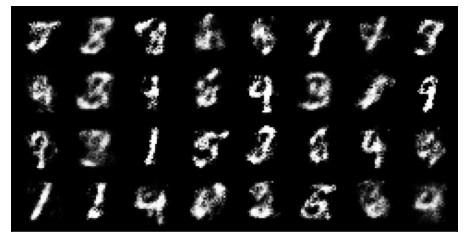

Epoch:18,   G_loss:1.623716806679138,    D_loss:1.0202418606418537


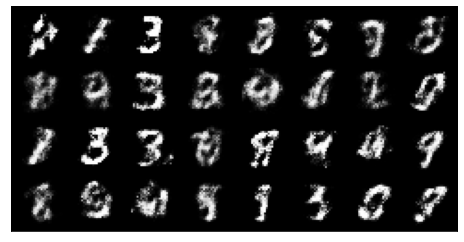

Epoch:19,   G_loss:1.6822394525318511,    D_loss:0.9686844041988031


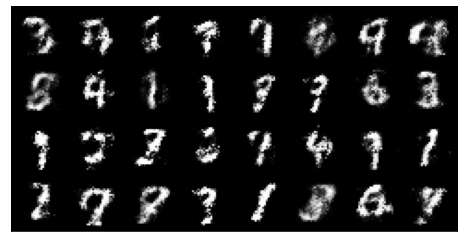

In [36]:
for epoch in range(20):
    G_loss_run = 0.0
    D_loss_run = 0.0
    for i, data in enumerate(train_loader):
        X, _ = data
        X = X.view(X.size(0), -1).to(device)
        mb_size = X.size(0)
        
        one_labels = torch.ones(mb_size, 1).to(device)
        zero_labels = torch.zeros(mb_size, 1).to(device)
        
        z = torch.randn(mb_size, Z_dim).to(device)
        
        D_real = D(X)
        D_fake = D(G(z))
        
        D_real_loss = F.binary_cross_entropy(D_real, one_labels)
        D_fake_loss = F.binary_cross_entropy(D_fake, zero_labels)
        D_loss = D_real_loss + D_fake_loss
        
        d_opt.zero_grad()
        D_loss.backward()
        d_opt.step()
        
        z = torch.randn(mb_size, Z_dim).to(device)
        D_fake = D(G(z))
        G_loss = F.binary_cross_entropy(D_fake, one_labels)
        
        g_opt.zero_grad()
        G_loss.backward()
        g_opt.step()
        
        G_loss_run += G_loss.item()
        D_loss_run += D_loss.item()
        
    print('Epoch:{},   G_loss:{},    D_loss:{}'.format(epoch, G_loss_run/(i+1), D_loss_run/(i+1)))
    
    samples = G(z).detach()
    samples = samples.view(samples.size(0), 1, 28, 28).cpu()
    imshow(samples)